# Football Match Outcome Prediction
Using Machine Learning to Predict European Soccer Match Results
**Dataset:** European Soccer Database (Kaggle)  
**Time Period:** 2008-2016  
**Matches:** 25,000+  
**Objective:** Predict Win/Draw/Loss outcomes using team attributes and betting odds

# Import Libraries and Setup


In [102]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score, roc_auc_score)
                             
# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

# Load Data from SQLite Database


In [103]:
# Database path
DB_PATH = r"database\database.sqlite"

def load_data(db_path):
    """Load all relevant tables from SQLite database"""
    conn = sqlite3.connect(db_path)
    
    # Load tables
    matches = pd.read_sql('SELECT * FROM "Match"', conn)
    teams = pd.read_sql('SELECT * FROM Team', conn)
    team_attributes = pd.read_sql('SELECT * FROM Team_Attributes', conn)
    
    conn.close()
    
    print(f"Successfully loaded:")
    print(f"   • {len(matches):,} matches")
    print(f"   • {len(teams):,} teams")
    print(f"   • {len(team_attributes):,} team attribute records")
    
    return matches, teams, team_attributes

# Load data
matches, teams, team_attributes = load_data(DB_PATH)

Successfully loaded:
   • 25,979 matches
   • 299 teams
   • 1,458 team attribute records


# Exploratory Data Analysis (EDA)

In [104]:
# Dataset overview
print("DATASET OVERVIEW")
print(f"\nDataset Shape: {matches.shape}")
print(f"   • Rows (Matches): {matches.shape[0]:,}")
print(f"   • Columns (Features): {matches.shape[1]}")

print("\nSample Data:")
matches.head()

DATASET OVERVIEW

Dataset Shape: (25979, 115)
   • Rows (Matches): 25,979
   • Columns (Features): 115

Sample Data:


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [105]:
# Check data types and missing values
print("DATA QUALITY CHECK")

# Analyze missing values
missing_data = matches.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if len(missing_data) > 0:
    print(f"\nMissing Values Found in {len(missing_data)} columns")
    
    # Calculate missing percentage
    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': (missing_data.values / len(matches) * 100).round(2)
    })
    
    print(f"\nTop 15 Columns with Missing Values:")
    print(missing_df.head(15).to_string(index=False))
    
    print(f"\nMissing Data Summary:")
    print(f"   • Total missing values: {missing_data.sum():,}")
    print(f"   • Columns affected: {len(missing_data)}/{len(matches.columns)}")
    
    # Categorize columns by missing percentage
    high_missing = missing_df[missing_df['Missing_Percentage'] > 50]
    medium_missing = missing_df[(missing_df['Missing_Percentage'] > 20) & 
                                (missing_df['Missing_Percentage'] <= 50)]
    low_missing = missing_df[missing_df['Missing_Percentage'] <= 20]
    
    print(f"\nMissing Data Breakdown:")
    print(f"   • High missing (>50%): {len(high_missing)} columns")
    print(f"   • Medium missing (20-50%): {len(medium_missing)} columns")
    print(f"   • Low missing (<20%): {len(low_missing)} columns")
else:
    print("No missing values found!")

DATA QUALITY CHECK

Missing Values Found in 104 columns

Top 15 Columns with Missing Values:
    Column  Missing_Count  Missing_Percentage
       PSH          14811               57.01
       PSD          14811               57.01
       PSA          14811               57.01
       BSH          11818               45.49
       BSD          11818               45.49
       BSA          11818               45.49
       GBA          11817               45.49
       GBD          11817               45.49
       GBH          11817               45.49
      card          11762               45.28
possession          11762               45.28
    corner          11762               45.28
   shotoff          11762               45.28
     cross          11762               45.28
foulcommit          11762               45.28

Missing Data Summary:
   • Total missing values: 407,395
   • Columns affected: 104/115

Missing Data Breakdown:
   • High missing (>50%): 3 columns
   • Medium missing (

In [106]:
# Identify column types for smart handling
print("COLUMN CATEGORIZATION")

# Core match information 
core_columns = ['id', 'country_id', 'league_id', 'season', 'stage', 'date',
                'home_team_api_id', 'away_team_api_id', 
                'home_team_goal', 'away_team_goal', 'match_api_id']

# Betting odds columns 
betting_columns = [col for col in matches.columns if any(
    bookie in col for bookie in ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 
                                  'VC', 'GB', 'BS']
)]

# Team and player columns
team_player_columns = [col for col in matches.columns if any(
    keyword in col for keyword in ['team', 'player', 'home', 'away']
)]

# Other match details
detail_columns = [col for col in matches.columns if col not in 
                 core_columns + betting_columns + team_player_columns]

print(f"\nColumn Categories:")
print(f"   • Core columns: {len(core_columns)}")
print(f"   • Betting odds: {len(betting_columns)}")
print(f"   • Team/Player: {len(team_player_columns)}")
print(f"   • Other details: {len(detail_columns)}")

COLUMN CATEGORIZATION

Column Categories:
   • Core columns: 11
   • Betting odds: 30
   • Team/Player: 70
   • Other details: 8


In [107]:
# Check betting odds availability
print("BETTING ODDS ANALYSIS")

# Main bookmakers to check
main_bookies = {
    'B365': ['B365H', 'B365D', 'B365A'],  # Bet365
    'BW': ['BWH', 'BWD', 'BWA'],          # Bet&Win
    'IW': ['IWH', 'IWD', 'IWA'],          # Interwetten
    'LB': ['LBH', 'LBD', 'LBA'],          # Ladbrokes
    'WH': ['WHH', 'WHD', 'WHA']           # William Hill
}

print("\nBetting Odds Availability:")
for bookie, cols in main_bookies.items():
    if all(col in matches.columns for col in cols):
        missing_pct = matches[cols].isnull().any(axis=1).sum() / len(matches) * 100
        available_pct = 100 - missing_pct
        print(f"   • {bookie:6s}: {available_pct:5.1f}% available")
    else:
        print(f"   • {bookie:6s}: Not in dataset")

BETTING ODDS ANALYSIS

Betting Odds Availability:
   • B365  :  87.0% available
   • BW    :  86.9% available
   • IW    :  86.7% available
   • LB    :  86.8% available
   • WH    :  86.9% available


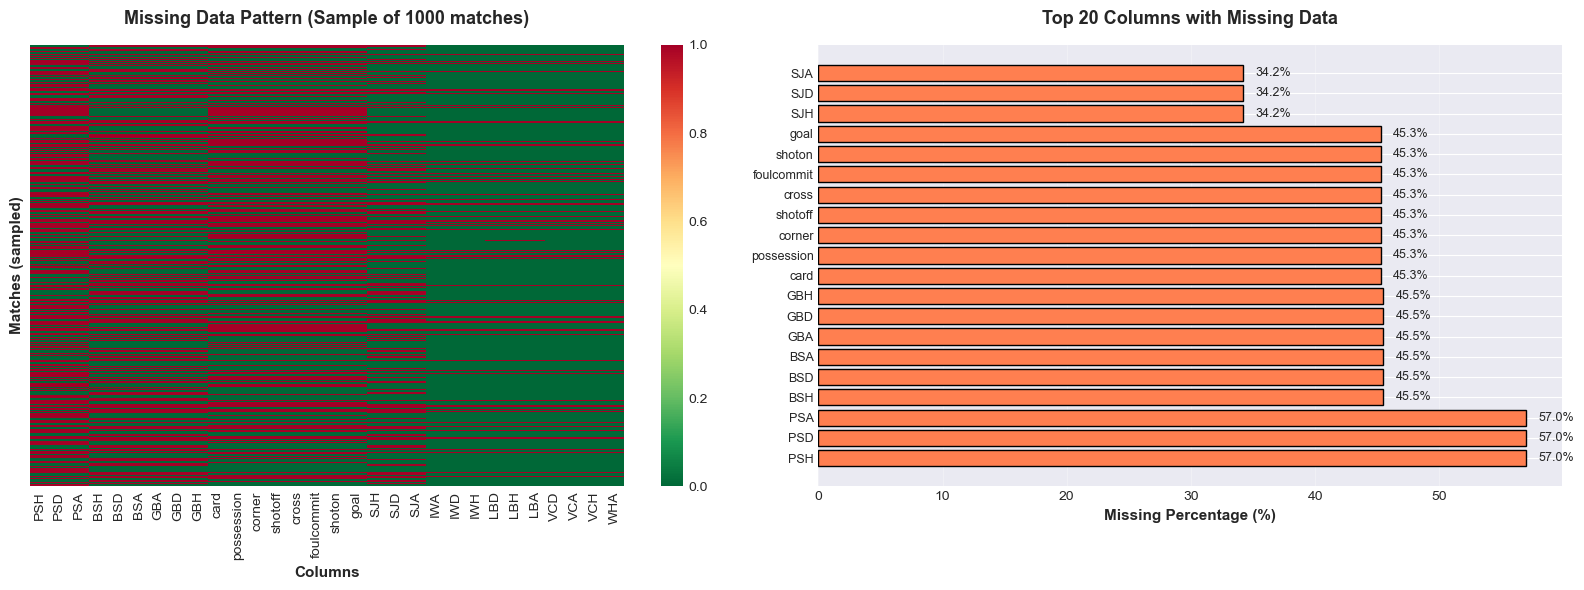

In [108]:
# Visualize missing data pattern

# Select columns for visualization (top 30 with most missing)
top_missing_cols = missing_data.head(30).index.tolist()
missing_matrix = matches[top_missing_cols].isnull()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Missing data heatmap
ax1 = axes[0]
# Sample 1000 rows for better visualization
sample_idx = np.random.choice(len(matches), min(1000, len(matches)), replace=False)
sns.heatmap(missing_matrix.iloc[sample_idx], 
            yticklabels=False, 
            cbar=True,
            cmap='RdYlGn_r',
            ax=ax1)
ax1.set_title('Missing Data Pattern (Sample of 1000 matches)', 
             fontsize=13, fontweight='bold', pad=15)
ax1.set_xlabel('Columns', fontsize=11, fontweight='bold')
ax1.set_ylabel('Matches (sampled)', fontsize=11, fontweight='bold')

# Plot 2: Missing percentage by column
ax2 = axes[1]
missing_pct = (missing_data.head(20) / len(matches) * 100)
bars = ax2.barh(range(len(missing_pct)), missing_pct, color='coral', 
                edgecolor='black', linewidth=1)
ax2.set_yticks(range(len(missing_pct)))
ax2.set_yticklabels(missing_pct.index, fontsize=9)
ax2.set_xlabel('Missing Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('Top 20 Columns with Missing Data', 
             fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (bar, val) in enumerate(zip(bars, missing_pct)):
    width = bar.get_width()
    ax2.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}%', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [109]:
# Clean the dataset - keep only essential columns
print("DATA CLEANING PROCESS")

# Select columns we actually need
essential_columns = [
    # Match identifiers
    'id', 'match_api_id', 'date', 'season', 'league_id',
    
    # Teams and results
    'home_team_api_id', 'away_team_api_id',
    'home_team_goal', 'away_team_goal',
    
    # Best available betting odds (Bet365)
    'B365H', 'B365D', 'B365A'
]

# Check which columns exist
available_essential = [col for col in essential_columns if col in matches.columns]
missing_essential = [col for col in essential_columns if col not in matches.columns]

print(f"\nAvailable essential columns: {len(available_essential)}/{len(essential_columns)}")
if missing_essential:
    print(f"Missing essential columns: {missing_essential}")

# Create clean dataset
matches_clean_base = matches[available_essential].copy()

print(f"\nDataset after selecting essential columns:")
print(f"   • Original shape: {matches.shape}")
print(f"   • New shape: {matches_clean_base.shape}")
print(f"   • Columns reduced: {matches.shape[1]} → {matches_clean_base.shape[1]}")

# Check missing values in essential columns
print(f"\nMissing values in essential columns:")
essential_missing = matches_clean_base.isnull().sum()
essential_missing = essential_missing[essential_missing > 0]

if len(essential_missing) > 0:
    for col, count in essential_missing.items():
        pct = (count / len(matches_clean_base)) * 100
        print(f"   • {col:20s}: {count:6,} ({pct:5.1f}%)")
else:
    print("No missing values in core match data!")

# Drop rows where core match data is missing
core_columns_check = ['home_team_api_id', 'away_team_api_id', 
                      'home_team_goal', 'away_team_goal']
matches_clean_base = matches_clean_base.dropna(subset=core_columns_check)

print(f"\nAfter dropping rows with missing core data:")
print(f"   • Remaining matches: {len(matches_clean_base):,}")
print(f"   • Data retention: {(len(matches_clean_base)/len(matches)*100):.1f}%")

DATA CLEANING PROCESS

Available essential columns: 12/12

Dataset after selecting essential columns:
   • Original shape: (25979, 115)
   • New shape: (25979, 12)
   • Columns reduced: 115 → 12

Missing values in essential columns:
   • B365H               :  3,387 ( 13.0%)
   • B365D               :  3,387 ( 13.0%)
   • B365A               :  3,387 ( 13.0%)

After dropping rows with missing core data:
   • Remaining matches: 25,979
   • Data retention: 100.0%


In [110]:
# Key statistics (using cleaned base data)
print("KEY STATISTICS")

print("\nGoals Statistics:")
print(matches_clean_base[['home_team_goal', 'away_team_goal']].describe())

print("\nDate Range:")
matches_clean_base['date'] = pd.to_datetime(matches_clean_base['date'])
print(f"   • First match: {matches_clean_base['date'].min()}")
print(f"   • Last match: {matches_clean_base['date'].max()}")
print(f"   • Duration: {(matches_clean_base['date'].max() - matches_clean_base['date'].min()).days} days")

# Update matches variable for subsequent analysis
matches = matches_clean_base.copy()


KEY STATISTICS

Goals Statistics:
       home_team_goal  away_team_goal
count    25979.000000    25979.000000
mean         1.544594        1.160938
std          1.297158        1.142110
min          0.000000        0.000000
25%          1.000000        0.000000
50%          1.000000        1.000000
75%          2.000000        2.000000
max         10.000000        9.000000

Date Range:
   • First match: 2008-07-18 00:00:00
   • Last match: 2016-05-25 00:00:00
   • Duration: 2868 days


# Data Processing

Load dữ liệu từ SQLite

In [111]:
con = sqlite3.connect(DB_PATH)

# Query lấy dữ liệu Match và Odds
query = """
SELECT
    m.match_api_id,
    m.date,
    m.season,
    m.league_id,
    m.home_team_api_id,
    m.away_team_api_id,
    m.home_team_goal,
    m.away_team_goal,
    m.B365H, m.B365D, m.B365A,
    m.BWH, m.BWD, m.BWA
FROM Match m
WHERE m.home_team_goal IS NOT NULL 
  AND m.away_team_goal IS NOT NULL
  AND m.date IS NOT NULL
"""
df = pd.read_sql_query(query, con)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

print(f"Tổng số trận: {df.shape[0]}")
df.head(3)

Tổng số trận: 25979


,match_api_id,date,season,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,BWD,BWA
0,486263,2008-07-18,2008/2009,24558,10192,9931,1,2,NaN,NaN,NaN,NaN,NaN,NaN
1,486264,2008-07-19,2008/2009,24558,9930,10179,3,1,NaN,NaN,NaN,NaN,NaN,NaN
2,486265,2008-07-20,2008/2009,24558,10199,9824,1,2,NaN,NaN,NaN,NaN,NaN,NaN


Tạo nhãn kết quả (Target Label)

In [112]:
conditions = [
    df["home_team_goal"] > df["away_team_goal"],
    df["home_team_goal"] == df["away_team_goal"],
    df["home_team_goal"] < df["away_team_goal"]
]
choices = ["Win", "Draw", "Loss"]

df["result"] = np.select(conditions, choices, default="Unknown")

# Kiểm tra tỉ lệ nhãn
print(" Tỉ lệ các nhãn:")
# Dùng astype(str) để đảm bảo không lỗi format
print(df["result"].value_counts(normalize=True).map('{:.2%}'.format))

 Tỉ lệ các nhãn:
result
Win     45.87%
Loss    28.74%
Draw    25.39%
Name: proportion, dtype: object


Label Encoding for y

In [113]:
label_map = {"Loss": 0, "Draw": 1, "Win": 2}
df["result_enc"] = df["result"].map(label_map).astype("Int64")

LABEL_ORDER = ["Loss", "Draw", "Win"]  # dùng cho confusion matrix/report
print(df["result"].value_counts())
print(df["result_enc"].value_counts())

result
Win     11917
Loss     7466
Draw     6596
Name: count, dtype: int64
result_enc
2    11917
0     7466
1     6596
Name: count, dtype: Int64


Xử lý dữ liệu lịch sử (Team History)

In [114]:
def build_team_history(df_matches):
    # Home stats
    home = df_matches[["date", "match_api_id", "home_team_api_id", "home_team_goal", "away_team_goal"]].copy()
    home.columns = ["date", "match_api_id", "team_id", "goals_for", "goals_against"]
    home["is_home"] = 1
    
    # Away stats
    away = df_matches[["date", "match_api_id", "away_team_api_id", "away_team_goal", "home_team_goal"]].copy()
    away.columns = ["date", "match_api_id", "team_id", "goals_for", "goals_against"]
    away["is_home"] = 0
    
    team_df = pd.concat([home, away], ignore_index=True).sort_values(["team_id", "date"])
    
    # Tính điểm (3=Thắng, 1=Hòa, 0=Thua)
    team_df["points"] = np.where(team_df["goals_for"] > team_df["goals_against"], 3,
                                 np.where(team_df["goals_for"] == team_df["goals_against"], 1, 0))
    return team_df

team_df = build_team_history(df)
print(f"Bảng lịch sử với {team_df.shape[0]} dòng.")
team_df.head(3)

Bảng lịch sử với 51958 dòng.


,date,match_api_id,team_id,goals_for,goals_against,is_home,points
26026,2008-08-10,506542,1601,0,0,0,1
85,2008-08-16,506549,1601,2,1,1,3
107,2008-08-22,506557,1601,2,1,1,3


Tạo Feature phong độ (Rolling Window)


In [115]:
def add_rolling_features(team_df, windows=(5, 10)):
    team_df = team_df.copy()

    # Goal difference + outcomes
    team_df["gd"] = team_df["goals_for"] - team_df["goals_against"]
    team_df["win"] = (team_df["gd"] > 0).astype(int)
    team_df["draw"] = (team_df["gd"] == 0).astype(int)

    g = team_df.groupby("team_id", sort=False)

    for w in windows:
        # Mean of previous w games (shift(1) => anti-leak)
        team_df[f"last{w}_points"] = g["points"].transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
        team_df[f"last{w}_gd"]     = g["gd"].transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
        team_df[f"last{w}_gf"]     = g["goals_for"].transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
        team_df[f"last{w}_ga"]     = g["goals_against"].transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
        team_df[f"last{w}_winrate"]= g["win"].transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
        team_df[f"last{w}_drawrate"]= g["draw"].transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())

    # how many games played before this match (experience)
    team_df["matches_played_before"] = g.cumcount()

    return team_df

team_df = add_rolling_features(team_df, windows=(5, 10))
team_df.head(3)

,date,match_api_id,team_id,goals_for,goals_against,is_home,points,gd,win,draw,last5_points,last5_gd,last5_gf,last5_ga,last5_winrate,last5_drawrate,last10_points,last10_gd,last10_gf,last10_ga,last10_winrate,last10_drawrate,matches_played_before
26026,2008-08-10,506542,1601,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
85,2008-08-16,506549,1601,2,1,1,3,1,1,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1
107,2008-08-22,506557,1601,2,1,1,3,1,1,0,2.0,0.5,1.0,0.5,0.5,0.5,2.0,0.5,1.0,0.5,0.5,0.5,2


Merge Features về lại bảng trận đấu

In [116]:
def merge_features(df_matches, team_df):
    # Feature columns created in rolling step
    feat_cols = [c for c in team_df.columns if c.startswith("last") or c == "matches_played_before"]

    # Home features
    home = team_df[team_df["is_home"] == 1][["match_api_id", "team_id"] + feat_cols].copy()
    home.rename(columns={"team_id": "home_team_api_id"}, inplace=True)
    home.rename(columns={c: f"home_{c}" for c in feat_cols}, inplace=True)

    # Away features
    away = team_df[team_df["is_home"] == 0][["match_api_id", "team_id"] + feat_cols].copy()
    away.rename(columns={"team_id": "away_team_api_id"}, inplace=True)
    away.rename(columns={c: f"away_{c}" for c in feat_cols}, inplace=True)

    out = df_matches.merge(home, on=["match_api_id", "home_team_api_id"], how="left")
    out = out.merge(away, on=["match_api_id", "away_team_api_id"], how="left")

    # diff = home - away
    for c in feat_cols:
        out[f"diff_{c}"] = out[f"home_{c}"] - out[f"away_{c}"]

    return out

df_final = merge_features(df, team_df)

# Sanity check: how many NaNs in engineered features?
diff_cols = [c for c in df_final.columns if c.startswith("diff_")]
print("Top missing diff features (%):")
print((df_final[diff_cols].isna().mean().sort_values(ascending=False).head(10) * 100).round(2))

df_final.head(3)

Top missing diff features (%):
diff_last5_points      0.79
diff_last5_gd          0.79
diff_last5_gf          0.79
diff_last5_ga          0.79
diff_last5_winrate     0.79
diff_last5_drawrate    0.79
diff_last10_points     0.79
diff_last10_gd         0.79
diff_last10_gf         0.79
diff_last10_ga         0.79
dtype: float64


,match_api_id,date,season,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,BWD,BWA,result,result_enc,home_last5_points,home_last5_gd,home_last5_gf,home_last5_ga,home_last5_winrate,home_last5_drawrate,home_last10_points,home_last10_gd,home_last10_gf,home_last10_ga,home_last10_winrate,home_last10_drawrate,home_matches_played_before,away_last5_points,away_last5_gd,away_last5_gf,away_last5_ga,away_last5_winrate,away_last5_drawrate,away_last10_points,away_last10_gd,away_last10_gf,away_last10_ga,away_last10_winrate,away_last10_drawrate,away_matches_played_before,diff_last5_points,diff_last5_gd,diff_last5_gf,diff_last5_ga,diff_last5_winrate,diff_last5_drawrate,diff_last10_points,diff_last10_gd,diff_last10_gf,diff_last10_ga,diff_last10_winrate,diff_last10_drawrate,diff_matches_played_before
0,486263,2008-07-18,2008/2009,24558,10192,9931,1,2,NaN,NaN,NaN,NaN,NaN,NaN,Loss,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,486264,2008-07-19,2008/2009,24558,9930,10179,3,1,NaN,NaN,NaN,NaN,NaN,NaN,Win,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,486265,2008-07-20,2008/2009,24558,10199,9824,1,2,NaN,NaN,NaN,NaN,NaN,NaN,Loss,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Implied Probabilities (normalized)

In [117]:
def add_implied_prob(df, book_prefix):
    # book_prefix: "B365" uses B365H/B365D/B365A ; "BW" uses BWH/BWD/BWA
    H, D, A = f"{book_prefix}H", f"{book_prefix}D", f"{book_prefix}A"
    if not all(col in df.columns for col in [H, D, A]):
        return df

    out = df.copy()

    invH = 1.0 / out[H].replace(0, np.nan)
    invD = 1.0 / out[D].replace(0, np.nan)
    invA = 1.0 / out[A].replace(0, np.nan)

    s = invH + invD + invA
    out[f"{book_prefix}_pH"] = invH / s
    out[f"{book_prefix}_pD"] = invD / s
    out[f"{book_prefix}_pA"] = invA / s

    return out

df_final = add_implied_prob(df_final, "B365")
df_final = add_implied_prob(df_final, "BW")

print(df_final[[c for c in df_final.columns if c.endswith(("_pH", "_pD", "_pA"))]].head(3))

   B365_pH  B365_pD  B365_pA  BW_pH  BW_pD  BW_pA
0      NaN      NaN      NaN    NaN    NaN    NaN
1      NaN      NaN      NaN    NaN    NaN    NaN
2      NaN      NaN      NaN    NaN    NaN    NaN


Split Train/Test và Pipeline làm sạch

In [118]:
# ===== [REPLACE: CELL A] Define features & time-based split =====
TARGET = "result_enc"

# Robust season_start parsing
df_final["season_start"] = pd.to_numeric(df_final["season"].astype(str).str.slice(0, 4), errors="coerce")
df_final = df_final.dropna(subset=["season_start", TARGET]).copy()
df_final["season_start"] = df_final["season_start"].astype(int)

# Feature sets
diff_cols = [c for c in df_final.columns if c.startswith("diff_")]

# Use implied probabilities (recommended)
prob_cols = [c for c in ["B365_pH","B365_pD","B365_pA","BW_pH","BW_pD","BW_pA"] if c in df_final.columns]

# (Optional) keep raw odds too (usually not needed if using prob_cols)
# odds_cols = [c for c in ["B365H","B365D","B365A","BWH","BWD","BWA"] if c in df_final.columns]

numeric_cols = diff_cols + prob_cols
cat_cols = ["league_id", "season"]  # season is known pre-match; helps capture season effects

# Time split
train_df = df_final[df_final["season_start"] <= 2014].copy()
test_df  = df_final[df_final["season_start"] >= 2015].copy()

X_train = train_df[numeric_cols + cat_cols]
y_train = train_df[TARGET].astype(int)

X_test  = test_df[numeric_cols + cat_cols]
y_test  = test_df[TARGET].astype(int)

print("Train label distribution:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Test  label distribution:", y_test.value_counts(normalize=True).round(3).to_dict())
print("X_train:", X_train.shape, "X_test:", X_test.shape)

Train label distribution: {2: 0.462, 0: 0.285, 1: 0.253}
Test  label distribution: {2: 0.439, 0: 0.304, 1: 0.257}
X_train: (22653, 21) X_test: (3326, 21)


In [119]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

In [120]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print("X_train_proc:", X_train_proc.shape)
print("X_test_proc :", X_test_proc.shape)

# Check NaNs after preprocessing
def count_nans(matrix):
    try:
        return np.isnan(matrix).sum()
    except:
        return np.isnan(matrix.toarray()).sum()

print("NaNs in X_train_proc:", count_nans(X_train_proc))
print("NaNs in X_test_proc :", count_nans(X_test_proc))

# ---- Class imbalance handling (balanced dataset requirement) ----
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0, 1, 2])  # Loss, Draw, Win
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train.values)
class_weight = dict(zip(classes, weights))

print("Class weights (use in models):", class_weight)


X_train_proc: (22653, 37)
X_test_proc : (3326, 37)
NaNs in X_train_proc: 0
NaNs in X_test_proc : 0
Class weights (use in models): {0: 1.1699721103191818, 1: 1.31527608430587, 2: 0.7220309810671256}


In [121]:
# ===== [OPTIONAL NEW CELL] Anti-leak sanity checks =====
leak_cols = ["home_team_goal", "away_team_goal"]
present_in_X = [c for c in leak_cols if c in (numeric_cols + cat_cols)]
print("Leak columns accidentally included in features:", present_in_X)

print("Min train season:", train_df["season_start"].min(), "Max train season:", train_df["season_start"].max())
print("Min test  season:", test_df["season_start"].min(),  "Max test  season:", test_df["season_start"].max())

Leak columns accidentally included in features: []
Min train season: 2008 Max train season: 2014
Min test  season: 2015 Max test  season: 2015


# Feature Engineering


In [122]:
print("FEATURE ENGINEERING")

# Analyze team attributes
print("\nTeam Attributes Overview:")
print(f"   • Total records: {len(team_attributes):,}")
print(f"   • Unique teams: {team_attributes['team_api_id'].nunique()}")

print("\nAvailable Attributes:")
attribute_cols = ['buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing',
                 'chanceCreationShooting', 'defencePressure', 'defenceAggression']
for col in attribute_cols:
    print(f"   • {col}")

FEATURE ENGINEERING

Team Attributes Overview:
   • Total records: 1,458
   • Unique teams: 288

Available Attributes:
   • buildUpPlaySpeed
   • buildUpPlayPassing
   • chanceCreationPassing
   • chanceCreationShooting
   • defencePressure
   • defenceAggression


In [123]:
# Aggregate team attributes (average across all seasons)
team_attr_avg = team_attributes.groupby('team_api_id').agg({
    'buildUpPlaySpeed': 'mean',
    'buildUpPlayPassing': 'mean',
    'chanceCreationPassing': 'mean',
    'chanceCreationShooting': 'mean',
    'defencePressure': 'mean',
    'defenceAggression': 'mean'
}).reset_index()

print(f"\nAggregated attributes for {len(team_attr_avg)} teams")
print("\nAttribute Statistics:")
team_attr_avg[attribute_cols].describe().round(2)


Aggregated attributes for 288 teams

Attribute Statistics:


,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationShooting,defencePressure,defenceAggression
count,288.00,288.00,288.00,288.00,288.00,288.00
mean,52.03,48.72,51.73,53.89,45.82,49.15
std,7.74,7.35,6.61,6.24,7.00,6.19
min,29.33,30.00,30.00,36.67,25.67,30.00
25%,47.30,44.00,48.00,50.20,41.30,45.60
50%,52.33,48.45,51.45,53.92,46.00,48.73
75%,57.35,53.17,55.70,58.00,50.04,52.83
max,72.50,77.00,68.83,70.00,70.00,70.00


In [124]:
# Merge team attributes with matches

# Merge home team attributes
matches_features = df_final.merge(
    team_attr_avg,
    left_on='home_team_api_id',
    right_on='team_api_id',
    how='left',
    suffixes=('', '_home')
)

# Merge away team attributes
matches_features = matches_features.merge(
    team_attr_avg,
    left_on='away_team_api_id',
    right_on='team_api_id',
    how='left',
    suffixes=('_home', '_away')
)

print(f"Merged successfully! Shape: {matches_features.shape}")

Merged successfully! Shape: (25979, 76)


In [125]:
# Define feature columns
feature_cols = [
    # Home team features
    'buildUpPlaySpeed_home', 'buildUpPlayPassing_home',
    'chanceCreationPassing_home', 'chanceCreationShooting_home',
    'defencePressure_home', 'defenceAggression_home',
    
    # Away team features
    'buildUpPlaySpeed_away', 'buildUpPlayPassing_away',
    'chanceCreationPassing_away', 'chanceCreationShooting_away',
    'defencePressure_away', 'defenceAggression_away'
]

# Add betting odds if available
betting_cols = ['B365H', 'B365D', 'B365A']
available_betting = [col for col in betting_cols if col in matches_features.columns]

if available_betting:
    feature_cols.extend(available_betting)
    print(f"\nAdded {len(available_betting)} betting odds features")

print(f"\nTotal Features: {len(feature_cols)}")
print("\nFeature List:")
for i, col in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {col}")


Added 3 betting odds features

Total Features: 15

Feature List:
    1. buildUpPlaySpeed_home
    2. buildUpPlayPassing_home
    3. chanceCreationPassing_home
    4. chanceCreationShooting_home
    5. defencePressure_home
    6. defenceAggression_home
    7. buildUpPlaySpeed_away
    8. buildUpPlayPassing_away
    9. chanceCreationPassing_away
   10. chanceCreationShooting_away
   11. defencePressure_away
   12. defenceAggression_away
   13. B365H
   14. B365D
   15. B365A


In [126]:
# Clean dataset - remove missing values
TARGET = "result_enc"
matches_clean = matches_features[feature_cols + [TARGET]].dropna()

print(f"\nDataset Statistics:")
print(f"   • Original matches: {len(matches):,}")
print(f"   • After merging: {len(matches_features):,}")
print(f"   • After cleaning: {len(matches_clean):,}")
print(f"   • Data retained: {(len(matches_clean)/len(matches)*100):.1f}%")

# Check class distribution
print("\nTarget Distribution (Clean Data):")
target_dist = matches_clean[TARGET].value_counts().sort_index()
target_labels = {0: 'Away Win', 1: 'Draw', 2: 'Home Win'}

for target, count in target_dist.items():
    pct = (count / len(matches_clean)) * 100
    print(f"   • {target_labels[target]:10s}: {count:5,} ({pct:5.2f}%)")


Dataset Statistics:
   • Original matches: 25,979
   • After merging: 25,979
   • After cleaning: 22,309
   • Data retained: 85.9%

Target Distribution (Clean Data):
   • Away Win  : 6,423 (28.79%)
   • Draw      : 5,647 (25.31%)
   • Home Win  : 10,239 (45.90%)


In [127]:
# Prepare final datasets
X = matches_clean[feature_cols]
y = matches_clean[TARGET]

print("FINAL DATASET READY FOR MODELING")
print(f"   • Features (X): {X.shape}")
print(f"   • Target (y): {y.shape}")
print(f"   • Classes: {sorted(y.unique())} → {list(target_labels.values())}")

FINAL DATASET READY FOR MODELING
   • Features (X): (22309, 15)
   • Target (y): (22309,)
   • Classes: [0, 1, 2] → ['Away Win', 'Draw', 'Home Win']
